<a href="https://colab.research.google.com/github/rizkyfauziilmi/TUGAS_UAS_ML/blob/main/clustering_data_kecil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import kagglehub

path_df = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

In [177]:
import pandas as pd

df = pd.read_csv(path_df + "/Mall_Customers.csv")

In [178]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# Data Cleaning

- standarisasi nama kolom

In [180]:
import re

def column_names(data: pd.DataFrame) -> pd.DataFrame:
    cleaned_columns = []
    for col in data.columns:
        col = re.sub(r'\([^)]*\)', '', col)  # Hilangkan isi dalam tanda kurung dan tanda kurungnya
        col = re.sub(r'\s+', '', col)  # Hilangkan semua spasi
        col = re.sub(r'[^a-zA-Z]', '', col)  # Hilangkan karakter selain huruf
        cleaned_columns.append(col)

    data.columns = cleaned_columns
    return data


In [181]:
df_clean = column_names(df)

df_clean.columns

Index(['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore'], dtype='object')

- atasi data duplicate

In [182]:
df_clean.duplicated().sum()

np.int64(0)

- atasi data missing

In [183]:
df_clean.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
AnnualIncome,0
SpendingScore,0


- atasi data anomali

In [184]:
df_clean.describe()

,CustomerID,Age,AnnualIncome,SpendingScore
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [185]:
def describe_categorical_columns(df: pd.DataFrame) -> None:
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    if len(categorical_cols) == 0:
        print("Tidak ada kolom kategorikal dalam DataFrame.")
        return

    for col in categorical_cols:
        print(f"\nKolom: {col}")
        print(df[col].value_counts(dropna=False))  # Termasuk NaN jika ada


In [186]:
describe_categorical_columns(df_clean)


Kolom: Gender
Gender
Female    112
Male       88
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

- visualisasi kolom kategorikal dan numerikal

In [187]:
df_clean.columns

Index(['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore'], dtype='object')

In [188]:
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
# CustomerID tidak termasuk analisis
numerical_cols = numerical_cols.drop("CustomerID")

categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: Index(['Age', 'AnnualIncome', 'SpendingScore'], dtype='object')
Categorical Columns: Index(['Gender'], dtype='object')


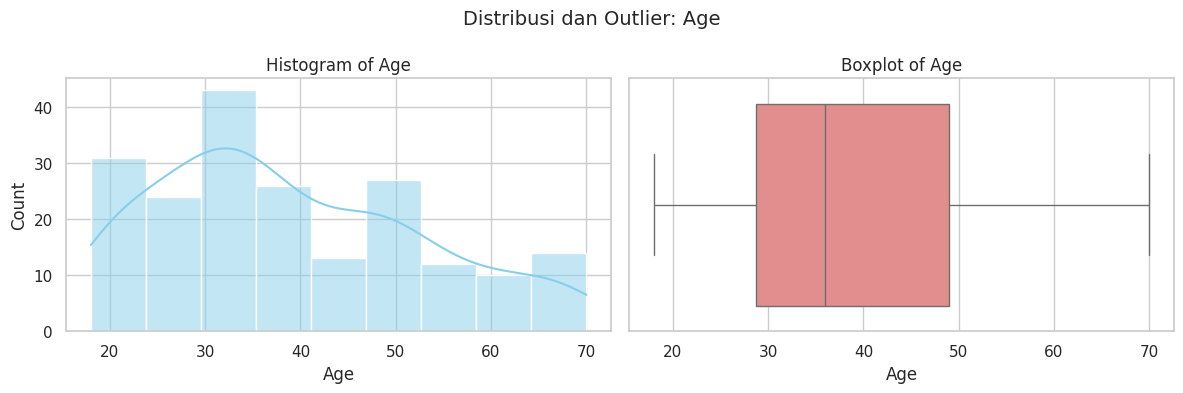

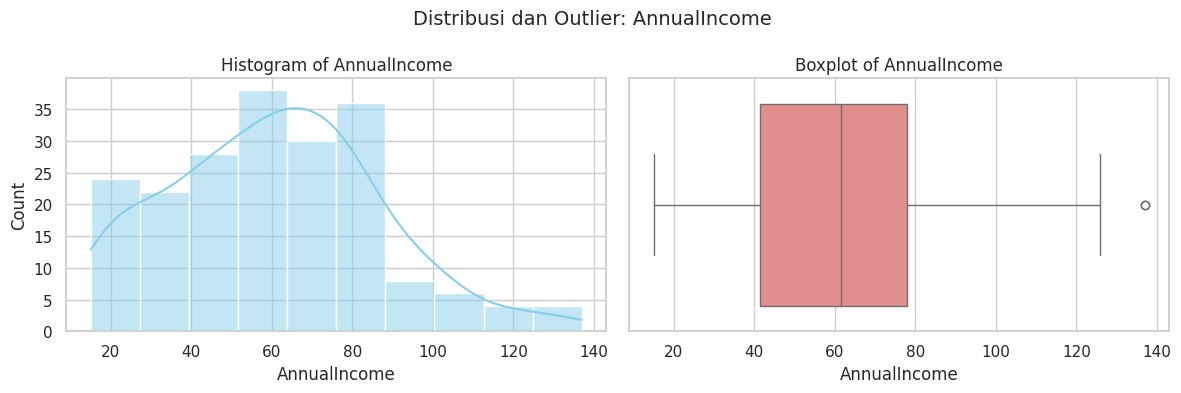

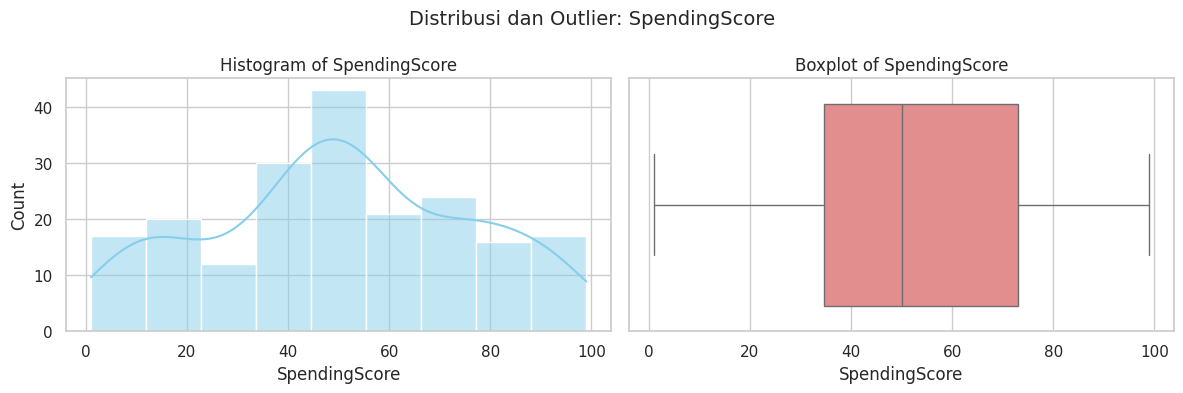

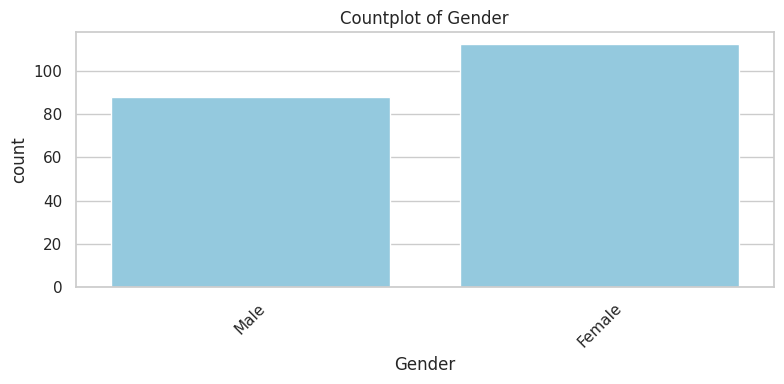

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --- Plot untuk kolom numerik ---
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Distribusi dan Outlier: {col}", fontsize=14)

    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Histogram of {col}")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightcoral")
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

# --- Plot untuk kolom kategorikal ---
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, color="skyblue")
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Feature Selection & Scaling

- memilih kolom

In [190]:
df_clean.columns

Index(['CustomerID', 'Gender', 'Age', 'AnnualIncome', 'SpendingScore'], dtype='object')

In [191]:
df_clean = df_clean.drop(columns=['CustomerID'])

In [192]:
df_clean.columns

Index(['Gender', 'Age', 'AnnualIncome', 'SpendingScore'], dtype='object')

- lakukan label encoding untuk kolom binary categorical

In [193]:
df_encoded = df_clean.copy()

In [194]:
lbl_encode_cols = ["Gender"]

In [195]:
def label_encode(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Melakukan label encoding untuk daftar kolom kategorikal.
    Encoding akan bersifat manual berdasarkan urutan unik yang muncul pertama.

    Parameters:
    df : DataFrame
        DataFrame input (tidak akan dimodifikasi secara in-place).
    columns : list
        List nama kolom kategorikal yang ingin di-encode.

    Returns:
    DataFrame baru dengan kolom tambahan hasil encoding.
    """
    if not columns:
        print("⚠️ Tidak ada kolom yang diberikan untuk label encoding.")
        return df.copy()

    df_encoded = df.copy()
    for col in columns:
        unique_vals = df_encoded[col].dropna().unique()

        mapping = {val: idx for idx, val in enumerate(unique_vals)}

        df_encoded[col + 'Encoded'] = df_encoded[col].map(mapping)
        print(f"Mapping untuk kolom '{col}': {mapping}")
    return df_encoded


In [196]:
df_encoded = label_encode(df_clean, lbl_encode_cols)

Mapping untuk kolom 'Gender': {'Male': 0, 'Female': 1}


In [197]:
df_encoded.head()

,Gender,Age,AnnualIncome,SpendingScore,GenderEncoded
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,1
3,Female,23,16,77,1
4,Female,31,17,40,1


- lakukan frequency encoding untuk kolom categorical
(tidak ada)

In [198]:
def frequency_encode(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Melakukan frequency encoding untuk beberapa kolom kategorikal.

    Parameters:
    df : DataFrame
        DataFrame input (tidak akan dimodifikasi secara in-place).
    columns : list
        List nama kolom kategorikal yang ingin di-encode.

    Returns:
    DataFrame baru dengan kolom tambahan hasil frequency encoding.
    """
    if not columns:
        print("⚠️ Tidak ada kolom yang diberikan untuk frequency encoding.")
        return df.copy()

    df_encoded = df.copy()
    for col in columns:
        freq_map = df_encoded[col].value_counts()
        df_encoded[col + '_FreqEncoded'] = df_encoded[col].map(freq_map)
        print(f"Top 5 Frequency Encoding untuk '{col}':\n{freq_map.head()}\n")
    return df_encoded

In [199]:
freq_encode_cols = []

df_encoded = frequency_encode(df_encoded, freq_encode_cols)

⚠️ Tidak ada kolom yang diberikan untuk frequency encoding.


- drop kolom kategori karena sudah diencode

In [200]:
df_encoded = df_encoded.drop(columns=categorical_cols)

In [201]:
df_encoded.head()

,Age,AnnualIncome,SpendingScore,GenderEncoded
0,19,15,39,0
1,21,15,81,0
2,20,16,6,1
3,23,16,77,1
4,31,17,40,1


- lakukan data scalling (normalisasi)

In [202]:
from sklearn.preprocessing import StandardScaler

In [203]:
# Inisiasi objek StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded[df_encoded.columns])

# Create a new DataFrame with scaled data
df_scaled = pd.DataFrame(scaled_data, columns=df_encoded.columns)

In [204]:
display(df_scaled.info())
display(df_scaled.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            200 non-null    float64
 1   AnnualIncome   200 non-null    float64
 2   SpendingScore  200 non-null    float64
 3   GenderEncoded  200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


None

,Age,AnnualIncome,SpendingScore,GenderEncoded
0,-1.424569,-1.738999,-0.434801,-1.128152
1,-1.281035,-1.738999,1.195704,-1.128152
2,-1.352802,-1.700830,-1.715913,0.886405
3,-1.137502,-1.700830,1.040418,0.886405
4,-0.563369,-1.662660,-0.395980,0.886405


- menampilkan similarity matrix

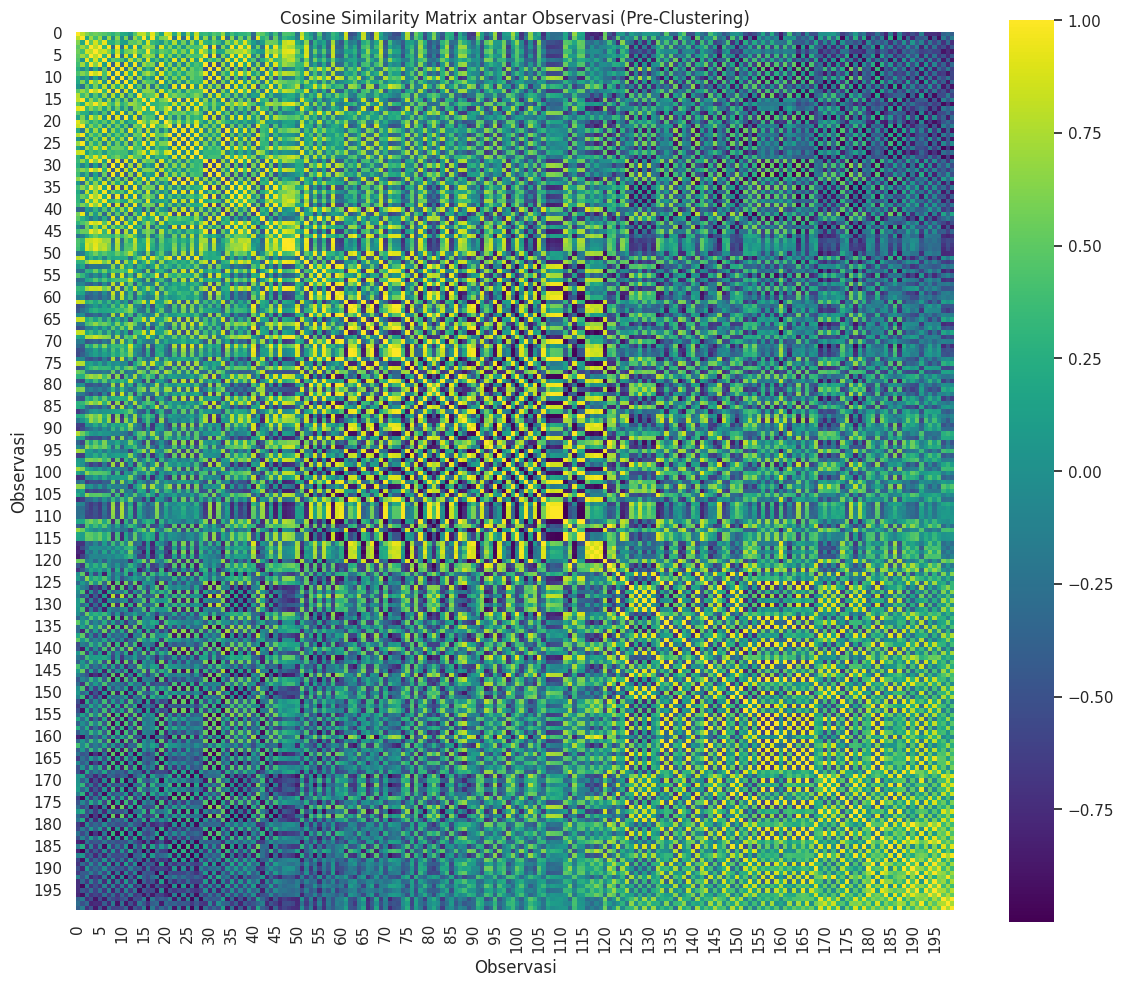

In [205]:
from sklearn.metrics.pairwise import cosine_similarity

# Hitung cosine similarity antar observasi (baris)
similarity_matrix = cosine_similarity(df_scaled)

# Ubah ke DataFrame agar bisa divisualisasikan
similarity_df = pd.DataFrame(similarity_matrix,
                             index=df_scaled.index,
                             columns=df_scaled.index)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, cmap='viridis', square=True)
plt.title('Cosine Similarity Matrix antar Observasi (Pre-Clustering)')
plt.xlabel('Observasi')
plt.ylabel('Observasi')
plt.tight_layout()
plt.show()


# K-Means Clustering (CPU)

In [206]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [207]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

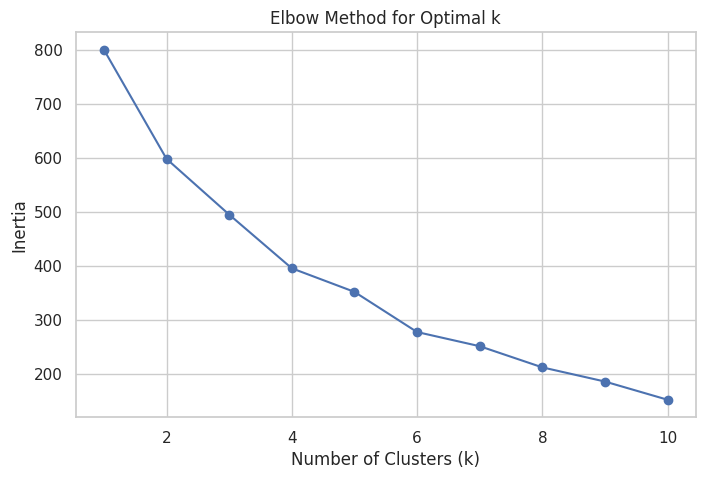

In [208]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [209]:
# Hitung relative score
relative_scores = []
for i in range(len(inertia) - 1):
    drop = (inertia[i] - inertia[i+1]) / inertia[i]
    relative_scores.append(drop)

# Cetak hasil relative scores
for i, score in enumerate(relative_scores, start=1):
    print(f"Relative Score k={i} → k={i+1}: {score:.2%}")

Relative Score k=1 → k=2: 25.26%
Relative Score k=2 → k=3: 17.25%
Relative Score k=3 → k=4: 20.09%
Relative Score k=4 → k=5: 11.04%
Relative Score k=5 → k=6: 21.14%
Relative Score k=6 → k=7: 9.46%
Relative Score k=7 → k=8: 15.60%
Relative Score k=8 → k=9: 12.39%
Relative Score k=9 → k=10: 18.14%


In [210]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)

df_pca['Cluster'] = cluster_labels

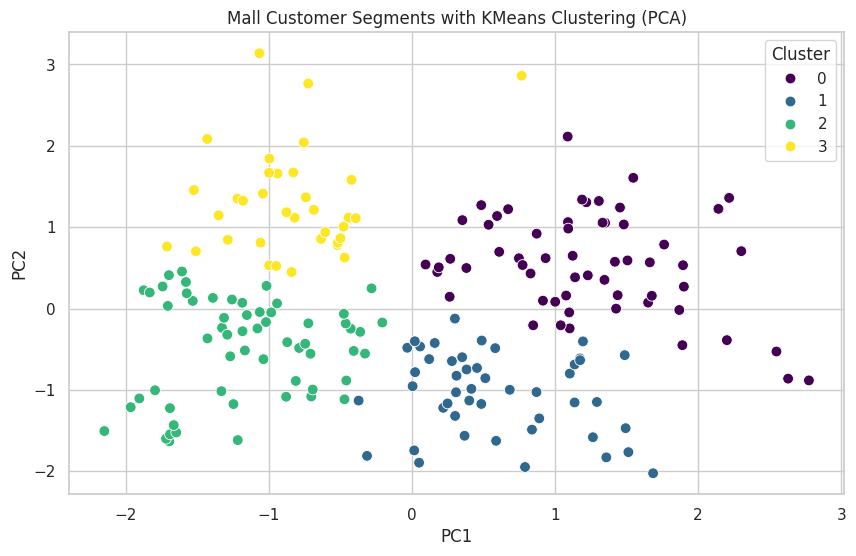

In [211]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', palette='viridis', data=df_pca, s=60
)
plt.title('Mall Customer Segments with KMeans Clustering (PCA)')
plt.show()

In [212]:
from sklearn.metrics import silhouette_score

score = silhouette_score(df_pca[['PC1', 'PC2']], df_pca['Cluster'])

print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.4123


# Interpretation

In [213]:
df_encoded['Cluster'] = cluster_labels

In [214]:
df_encoded.head()

,Age,AnnualIncome,SpendingScore,GenderEncoded,Cluster
0,19,15,39,0,2
1,21,15,81,0,2
2,20,16,6,1,1
3,23,16,77,1,2
4,31,17,40,1,1


## 📊 Mall Customer Segmentation Summary



In [215]:
categorical_encoded_to_summarize = [col + "Encoded" for col in lbl_encode_cols] + [col + "Encoded" for col in freq_encode_cols]

In [216]:
import numpy as np

# Ambil fitur asli (tanpa encoded & cluster)
features_to_summarize = df_encoded.drop(columns=categorical_encoded_to_summarize + ["Cluster"]).columns
cluster_means = df_encoded.groupby('Cluster')[features_to_summarize].mean()

# Ambil kuartil dari keseluruhan dataset (bukan per cluster)
quantiles = df_encoded[features_to_summarize].quantile([0.25, 0.5, 0.75])

# Fungsi untuk mengubah nilai rata-rata menjadi label kategori
def categorize(value, feature):
    if value < quantiles.loc[0.25, feature]:
        return "Very Low"
    elif value < quantiles.loc[0.5, feature]:
        return "Low"
    elif value < quantiles.loc[0.75, feature]:
        return "Medium"
    else:
        return "High"

# Terapkan ke semua nilai dalam cluster_means
categorized_summary = cluster_means.copy()
for feature in features_to_summarize:
    categorized_summary[feature] = cluster_means[feature].apply(lambda x: categorize(x, feature))

# Tampilkan hasil
display(categorized_summary)

,Age,AnnualIncome,SpendingScore
Cluster,,,
0,High,Medium,Very Low
1,Medium,Low,Low
2,Very Low,Low,Medium
3,Low,High,Medium


| 🧭 Cluster | 🎯 Segment Name         | Age      | Annual Income | Spending Score | 📝 Description                                                                                                                |
| ---------- | ----------------------- | -------- | ------------- | -------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| **0**      | 🧓 Senior Hemat         | High     | Medium        | Very Low       | Pelanggan usia lanjut dengan pendapatan cukup tetapi pola belanja sangat hemat. Kemungkinan fokus pada tabungan atau pensiun. |
| **1**      | 👴 Tradisional Ekonomis | Medium   | Low           | Low            | Pelanggan usia menengah dengan penghasilan dan pengeluaran rendah. Cenderung berhati-hati dalam berbelanja.                   |
| **2**      | 👶 Muda Berkembang      | Very Low | Low           | Medium         | Pelanggan sangat muda dengan pendapatan rendah namun mulai aktif berbelanja. Potensial untuk segmen tumbuh.                   |
| **3**      | 🧑 Profesional Muda     | Low      | High          | Medium         | Pelanggan muda dengan pendapatan tinggi dan pengeluaran cukup besar. Menunjukkan gaya hidup konsumtif kelas menengah ke atas. |

In [217]:
# Reassign original Gender and Profession to the encoded dataframe
df_encoded['GenderEncoded'] = df['Gender']

In [218]:
def summarize_categorical_by_cluster(df: pd.DataFrame, cat_cols: list) -> None:
    for cat_col in cat_cols:
      # Hitung jumlah
      summary_count = df.groupby(["Cluster", cat_col]).size().unstack(fill_value=0)

      # Hitung persentase
      summary_pct = summary_count.div(summary_count.sum(axis=1), axis=0) * 100

      # Tambahkan total anggota per cluster
      summary_count['Total'] = summary_count.sum(axis=1)
      summary_pct['Total'] = 100.0  # karena persentase total selalu 100

      print(f"📊 Count of {cat_col} per Cluster:")
      display(summary_count)

      print(f"\n📈 Percentage of {cat_col} per Cluster:")
      display(summary_pct.round(2))

In [219]:
summarize_categorical_by_cluster(df_encoded, categorical_encoded_to_summarize)

📊 Count of GenderEncoded per Cluster:


GenderEncoded,Female,Male,Total
Cluster,,,
0,13,45,58
1,44,3,47
2,49,11,60
3,6,29,35



📈 Percentage of GenderEncoded per Cluster:


GenderEncoded,Female,Male,Total
Cluster,,,
0,22.41,77.59,100.0
1,93.62,6.38,100.0
2,81.67,18.33,100.0
3,17.14,82.86,100.0


| Cluster | Gender (F/M %)        |
| ------- | --------------------- |
| 0       | 👩 22.41% / 👨 77.59% |
| 1       | 👩 93.62% / 👨 6.38%  |
| 2       | 👩 81.67% / 👨 18.33% |
| 3       | 👩 17.14% / 👨 82.86% |


In [241]:
cluster_percentages = (
    df_encoded['Cluster']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .sort_values(ascending=False)
)

# Ubah menjadi DataFrame agar lebih rapi
cluster_stats = cluster_percentages.reset_index()
cluster_stats.columns = ['Cluster', 'Percentage (%)']

cluster_stats

,Cluster,Percentage (%)
0,2,30.0
1,0,29.0
2,1,23.5
3,3,17.5


👶 **Cluster 2: Muda Berkembang (30.0%)**
- **Profil:** Sebagian besar wanita sangat muda, pendapatan rendah, mulai aktif berbelanja (👩 81.67% / 👨 18.33%).
- **Strategi:** Bangun loyalitas sejak dini dengan program member pemula, edukasi gaya hidup, dan promosi tren kekinian.
- **Aksi:** Adakan event komunitas muda, promo cashback, dan kolaborasi dengan brand fashion/teknologi entry-level.

---

🧓 **Cluster 0: Senior Hemat (29.0%)**
- **Profil:** Mayoritas pria usia lanjut, pendapatan menengah, sangat hemat dalam berbelanja (👩 22.41% / 👨 77.59%).
- **Strategi:** Tawarkan program loyalitas berbasis tabungan, diskon khusus lansia, dan fasilitas kenyamanan (misal: lounge senior, konsultasi keuangan).
- **Aksi:** Adakan event kesehatan, seminar pensiun, dan promosi produk kebutuhan pokok dengan harga spesial.

---

👴 **Cluster 1: Tradisional Ekonomis (23.5%)**
- **Profil:** Didominasi wanita usia menengah, penghasilan dan pengeluaran rendah, sangat berhati-hati dalam belanja (👩 93.62% / 👨 6.38%).
- **Strategi:** Fokus pada produk kebutuhan sehari-hari dengan harga terjangkau dan promo bundling.
- **Aksi:** Sediakan paket hemat, diskon belanja bulanan, dan edukasi keuangan keluarga.

---

🧑 **Cluster 3: Profesional Muda (17.5%)**
- **Profil:** Mayoritas pria muda, pendapatan tinggi, pengeluaran cukup besar, gaya hidup konsumtif (👩 17.14% / 👨 82.86%).
- **Strategi:** Tawarkan produk premium, pengalaman belanja eksklusif, dan fasilitas gaya hidup modern.
- **Aksi:** Launching produk baru, event networking, akses VIP, dan promo gadget/fashion kelas atas.

---

**Kesimpulan Umum:**  
Mall Anda memiliki segmen pelanggan yang sangat beragam, mulai dari senior hemat hingga profesional muda konsumtif. Untuk memaksimalkan potensi setiap segmen, lakukan pendekatan yang personal dan relevan sesuai karakteristik demografis dan perilaku belanja masing-masing cluster. Diversifikasi program promosi dan fasilitas akan meningkatkan loyalitas dan nilai transaksi di seluruh segmen pelanggan.
